In [1]:
# Hybrid Linear Regression + Random Forest Regression

# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings # getting lots of user warnings from sklearn
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

pd.options.display.float_format = '{:,.2f}'.format

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML

# Initialize lists to collect model performance
model_names = []
model_maes = []
model_mabs = []

In [2]:
data_set = pd.read_csv('MultipleSources-2019-2025-Ascending.csv')
data_set.head()
data_set.tail()

,Date,SP500,Futures,Nikkei,FTSE,DAX
0,04/03/19,"2,873.40","2,879.75","21,713.21","7,418.28","11,954.40"
1,04/04/19,"2,879.39","2,882.75","21,724.95","7,401.94","11,988.01"
2,04/05/19,"2,892.74","2,896.00","21,807.50","7,446.87","12,009.75"
3,04/08/19,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40"
4,04/09/19,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57"


,Date,SP500,Futures,Nikkei,FTSE,DAX
1516,04/14/25,"5,405.97","5,440.75","33,982.36","8,134.34","20,954.83"
1517,04/15/25,"5,396.63","5,386.25","34,267.54","8,249.12","21,253.70"
1518,04/16/25,"5,275.70","5,305.75","33,920.40","8,275.60","21,311.02"
1519,04/17/25,"5,282.70","5,312.75","34,730.28","8,275.66","21,205.86"
1520,04/21/25,"5,158.20","5,184.00","34,279.92",NaN,NaN


In [3]:
data_set.columns
data_set['Date'] = pd.to_datetime(data_set['Date'])
# get day of week
data_set['day_of_week'] = data_set['Date'].dt.dayofweek
data_set['Date'] = data_set['Date'].astype(np.int64) // 10**9
data_set.tail()

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX'], dtype='object')

,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week
1516,1744588800,"5,405.97","5,440.75","33,982.36","8,134.34","20,954.83",0
1517,1744675200,"5,396.63","5,386.25","34,267.54","8,249.12","21,253.70",1
1518,1744761600,"5,275.70","5,305.75","33,920.40","8,275.60","21,311.02",2
1519,1744848000,"5,282.70","5,312.75","34,730.28","8,275.66","21,205.86",3
1520,1745193600,"5,158.20","5,184.00","34,279.92",NaN,NaN,0


In [4]:
# Reshape as required by OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
day_of_week_encoded = encoder.fit_transform(data_set[['day_of_week']])

In [5]:
# day of week as feature
encoded_cols = encoder.get_feature_names_out(['day_of_week'])
encoded_df = pd.DataFrame(day_of_week_encoded, columns=encoded_cols, index=data_set.index)
data_set = pd.concat([data_set.drop(columns=['day_of_week']), encoded_df], axis=1)

In [6]:
def add_lag_features(df, columns, lags):
    """  Add lag features for columns and lag days.
    columns (list): Columns for which to create lag features
    lags (list): List of lag values (e.g., [1, 2, 3]) """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

lag_columns = ['SP500', 'DAX', 'FTSE', 'Nikkei']
lag_days = [1, 2, 3] 

data_set = add_lag_features(data_set, lag_columns, lag_days)
data_set = data_set.dropna()
data_set.head()

data_set = data_set.sort_values(by='Date').reset_index(drop=True)

,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,...,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
3,1554681600,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40",1.00,0.00,0.00,0.00,...,"2,873.40","12,009.75","11,988.01","11,954.40","7,446.87","7,401.94","7,418.28","21,807.50","21,724.95","21,713.21"
4,1554768000,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57",0.00,1.00,0.00,0.00,...,"2,879.39","11,963.40","12,009.75","11,988.01","7,451.89","7,446.87","7,401.94","21,761.65","21,807.50","21,724.95"
5,1554854400,"2,888.21","2,894.50","21,687.57","7,421.91","11,905.91",0.00,0.00,1.00,0.00,...,"2,892.74","11,850.57","11,963.40","12,009.75","7,425.57","7,451.89","7,446.87","21,802.59","21,761.65","21,807.50"
6,1554940800,"2,888.32","2,891.75","21,711.38","7,417.95","11,935.20",0.00,0.00,0.00,1.00,...,"2,895.77","11,905.91","11,850.57","11,963.40","7,421.91","7,425.57","7,451.89","21,687.57","21,802.59","21,761.65"
7,1555027200,"2,907.41","2,912.50","21,870.56","7,437.06","11,999.93",0.00,0.00,0.00,0.00,...,"2,878.20","11,935.20","11,905.91","11,850.57","7,417.95","7,421.91","7,425.57","21,711.38","21,687.57","21,802.59"


In [7]:
print(data_set.columns)

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3'],
      dtype='object')


In [8]:
# Create target columns first
data_set['SP500_next'] = data_set['SP500'].shift(-1)
data_set['Nikkei_next'] = data_set['Nikkei'].shift(-1)
data_set['FTSE_next'] = data_set['FTSE'].shift(-1)
data_set['DAX_next'] = data_set['DAX'].shift(-1)

# drop any new rows with NaNs
data_set = data_set.dropna()

In [9]:
# Drop the 'Date' and target columns to get features
features = data_set.drop(columns=['Date', 'SP500_next', 'Nikkei_next', 'FTSE_next', 'DAX_next'])
targets = data_set[['SP500_next', 'Nikkei_next', 'FTSE_next', 'DAX_next']]

# Apply StandardScaler to features only
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Rebuild the scaled DataFrame
data_scaled = pd.DataFrame(scaled_features, columns=features.columns)
data_scaled = pd.concat([data_scaled, targets], axis=1)

In [10]:
print(data_scaled.columns)

Index(['SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3', 'SP500_next', 'Nikkei_next',
       'FTSE_next', 'DAX_next'],
      dtype='object')


In [11]:
# for each stock index_next 

# Parameters for sliding window
window_size = 10
train_size = 8
test_size = 2

X_full = data_scaled.drop(columns=['SP500_next', 'Nikkei_next', 'FTSE_next', 'DAX_next'])
y_full = data_scaled['SP500_next']

# Containers to hold concatenated training and testing data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Sliding window generation
for start in range(0, len(X_full) - window_size + 1, test_size):  # step by test size
    end = start + window_size
    X_window = X_full.iloc[start:end]
    y_window = y_full.iloc[start:end]
    
    X_train_list.append(X_window.iloc[:train_size])
    y_train_list.append(y_window.iloc[:train_size])
    X_test_list.append(X_window.iloc[train_size:])
    y_test_list.append(y_window.iloc[train_size:])

# Concatenate all windows together to get final train-test sets
X_train = pd.concat(X_train_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)
X_test = pd.concat(X_test_list, ignore_index=True)
y_test = pd.concat(y_test_list, ignore_index=True)

In [12]:
### for Nikkei
# Parameters for sliding window
window_size = 10
train_size = 8
test_size = 2

X_full_nk = data_scaled.drop(columns=['SP500_next', 'Nikkei_next', 'FTSE_next', 'DAX_next'])
y_full_nk = data_scaled['Nikkei_next']

# Containers to hold concatenated training and testing data
X_train_list_nk, X_test_list_nk = [], []
y_train_list_nk, y_test_list_nk = [], []

# Sliding window generation
for start in range(0, len(X_full_nk) - window_size + 1, test_size):  # step by test size
    end = start + window_size
    X_window_nk = X_full_nk.iloc[start:end]
    y_window_nk = y_full_nk.iloc[start:end]

    X_train_list_nk.append(X_window_nk.iloc[:train_size])
    y_train_list_nk.append(y_window_nk.iloc[:train_size])
    X_test_list_nk.append(X_window_nk.iloc[train_size:])
    y_test_list_nk.append(y_window_nk.iloc[train_size:])

# Concatenate all windows together to get final train-test sets
X_train_nk = pd.concat(X_train_list_nk, ignore_index=True)
y_train_nk = pd.concat(y_train_list_nk, ignore_index=True)
X_test_nk = pd.concat(X_test_list_nk, ignore_index=True)
y_test_nk = pd.concat(y_test_list_nk, ignore_index=True)

In [13]:
### for FTSE
# Parameters for sliding window
window_size = 10
train_size = 8
test_size = 2

# Drop target from features and extract y values
X_full_fs = data_scaled.drop(columns=['SP500_next', 'Nikkei_next', 'FTSE_next', 'DAX_next'])
y_full_fs = data_scaled['FTSE_next']

# Lists to hold the training and testing splits
X_train_list_fs, X_test_list_fs = [], []
y_train_list_fs, y_test_list_fs = [], []

# Sliding window generation loop
for start in range(0, len(X_full_fs) - window_size + 1, test_size):  # step by test_size
    end = start + window_size
    X_window_fs = X_full_fs.iloc[start:end]
    y_window_fs = y_full_fs.iloc[start:end]

    X_train_list_fs.append(X_window_fs.iloc[:train_size])
    y_train_list_fs.append(y_window_fs.iloc[:train_size])
    X_test_list_fs.append(X_window_fs.iloc[train_size:])
    y_test_list_fs.append(y_window_fs.iloc[train_size:])

# Concatenate all windows together
X_train_fs = pd.concat(X_train_list_fs, ignore_index=True)
y_train_fs = pd.concat(y_train_list_fs, ignore_index=True)
X_test_fs = pd.concat(X_test_list_fs, ignore_index=True)
y_test_fs = pd.concat(y_test_list_fs, ignore_index=True)

In [14]:
### For DAX
# Parameters for sliding window
window_size = 10
train_size = 8
test_size = 2

# Drop target from features and extract y values
X_full_dx = data_scaled.drop(columns=['SP500_next', 'Nikkei_next', 'FTSE_next', 'DAX_next'])
y_full_dx = data_scaled['DAX_next']

# Lists to hold the training and testing splits
X_train_list_dx, X_test_list_dx = [], []
y_train_list_dx, y_test_list_dx = [], []

# Sliding window generation loop
for start in range(0, len(X_full_dx) - window_size + 1, test_size):  # step by test_size
    end = start + window_size
    X_window_dx = X_full_dx.iloc[start:end]
    y_window_dx = y_full_dx.iloc[start:end]

    X_train_list_dx.append(X_window_dx.iloc[:train_size])
    y_train_list_dx.append(y_window_dx.iloc[:train_size])
    X_test_list_dx.append(X_window_dx.iloc[train_size:])
    y_test_list_dx.append(y_window_dx.iloc[train_size:])

# Concatenate all windows together
X_train_dx = pd.concat(X_train_list_dx, ignore_index=True)
y_train_dx = pd.concat(y_train_list_dx, ignore_index=True)
X_test_dx = pd.concat(X_test_list_dx, ignore_index=True)
y_test_dx = pd.concat(y_test_list_dx, ignore_index=True)

# Hybrid for S&P500

In [15]:
# create for each index

model = LinearRegression(fit_intercept = True)
model.fit(X_train, y_train) 

# The following gives the R-square score
model.score(X_train, y_train) 

model.feature_names_in_


LinearRegression()

0.9959135976563152

array(['SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1',
       'DAX_lag_2', 'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3',
       'Nikkei_lag_1', 'Nikkei_lag_2', 'Nikkei_lag_3'], dtype=object)

In [16]:
training_residuals = y_train - model.predict(X_train)

In [17]:
rf = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf = rf.fit(X_train, training_residuals) 

In [18]:
pred_residuals = rf.predict(X_test)
y_pred = pred_residuals + model.predict(X_test)

In [19]:
test_output = pd.DataFrame(y_pred, index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Hybrid Model")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,933.95","2,939.88"
1,"2,883.25","2,881.40"
2,"2,827.80","2,811.87"
3,"2,833.72","2,834.41"
4,"2,849.66","2,850.96"


Mean absolute error is 
5.575971488983003
Mean absolute percentage error is 
0.0013263878965601493


In [20]:
# Training R²
train_hybrid_pred = model.predict(X_train) + rf.predict(X_train)
hybrid_r2_train = r2_score(y_train, train_hybrid_pred)
print(f"Hybrid Model R² score on training set: {hybrid_r2_train:.4f}")

# Test R² (y_pred is already calculated above)
hybrid_r2_test = r2_score(y_test, y_pred)
print(f"Hybrid Model R² score on test set: {hybrid_r2_test:.4f}")

Hybrid Model R² score on training set: 0.9999
Hybrid Model R² score on test set: 0.9998


# Hybrid Model for Nikkei

In [21]:
model_nk = LinearRegression(fit_intercept = True)
model_nk.fit(X_train_nk, y_train_nk) 

# The following gives the R-square score
model_nk.score(X_train_nk, y_train_nk) 

LinearRegression()

0.994870239991317

In [22]:
training_residuals_nk = y_train_nk - model_nk.predict(X_train_nk)

In [23]:
rf_nk = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf_nk = rf_nk.fit(X_train_nk, training_residuals_nk) 

In [24]:
pred_residuals_nk = rf_nk.predict(X_test_nk)
y_pred_nk = pred_residuals_nk + model_nk.predict(X_test_nk)

In [25]:
test_output = pd.DataFrame(y_pred_nk, index = X_test_nk.index, columns = ['pred_Nikkei_next'])
test_output = test_output.merge(y_test_nk, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_Nikkei_next'] - test_output['Nikkei_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_Nikkei_next'] - test_output['Nikkei_next']).mean() / test_output['Nikkei_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Hybrid Model")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_Nikkei_next,Nikkei_next
0,"22,226.04","22,258.73"
1,"21,557.70","21,344.92"
2,"21,268.97","21,191.28"
3,"21,048.67","21,067.23"
4,"21,178.56","21,188.56"


Mean absolute error is 
40.28634935525182
Mean absolute percentage error is 
0.0013802821738920616


In [26]:
from sklearn.metrics import r2_score

# Predict hybrid values on training set
train_hybrid_pred_nk = model_nk.predict(X_train_nk) + rf_nk.predict(X_train_nk)
hybrid_r2_train_nk = r2_score(y_train_nk, train_hybrid_pred_nk)
print(f"Hybrid Model R² score on training set (Nikkei): {hybrid_r2_train_nk:.4f}")

# Predict hybrid values on test set (y_pred_nk is already calculated)
hybrid_r2_test_nk = r2_score(y_test_nk, y_pred_nk)
print(f"Hybrid Model R² score on test set (Nikkei): {hybrid_r2_test_nk:.4f}")

Hybrid Model R² score on training set (Nikkei): 0.9998
Hybrid Model R² score on test set (Nikkei): 0.9998


# Hybrid for FTSE 

In [27]:
model_fs = LinearRegression(fit_intercept = True)
model_fs.fit(X_train_fs, y_train_fs) 

# The following gives the R-square score
model_fs.score(X_train_fs, y_train_fs) 

LinearRegression()

0.9850209404286906

In [28]:
training_residuals_fs = y_train_fs - model_fs.predict(X_train_fs)

In [29]:
rf_fs = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf_fs = rf_fs.fit(X_train_fs, training_residuals_fs) 

In [30]:
pred_residuals_fs = rf_fs.predict(X_test_fs)
y_pred_fs = pred_residuals_fs + model_fs.predict(X_test_fs)

In [31]:
test_output = pd.DataFrame(y_pred_fs, index = X_test_fs.index, columns = ['pred_FTSE_next'])
test_output = test_output.merge(y_test_fs, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_FTSE_next'] - test_output['FTSE_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_FTSE_next'] - test_output['FTSE_next']).mean() / test_output['FTSE_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Gradient Boosting Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_FTSE_next,FTSE_next
0,"7,419.69","7,428.19"
1,"7,234.35","7,203.29"
2,"7,173.25","7,163.68"
3,"7,233.77","7,241.60"
4,"7,291.36","7,296.95"


Mean absolute error is 
7.935565454755899
Mean absolute percentage error is 
0.00108191623238732


In [32]:
from sklearn.metrics import r2_score

# Predict hybrid values on training set
train_hybrid_pred_fs = model_fs.predict(X_train_fs) + rf_fs.predict(X_train_fs)
hybrid_r2_train_fs = r2_score(y_train_fs, train_hybrid_pred_fs)
print(f"Hybrid Model R² score on training set (FTSE): {hybrid_r2_train_fs:.4f}")

# Predict hybrid values on test set
hybrid_r2_test_fs = r2_score(y_test_fs, y_pred_fs)
print(f"Hybrid Model R² score on test set (FTSE): {hybrid_r2_test_fs:.4f}")

Hybrid Model R² score on training set (FTSE): 0.9994
Hybrid Model R² score on test set (FTSE): 0.9994


# Hybrid for DAX

In [33]:
model_dx = LinearRegression(fit_intercept = True)
model_dx.fit(X_train_dx, y_train_dx) 

# The following gives the R-square score
model_dx.score(X_train_dx, y_train_dx) 

LinearRegression()

0.9937239790484894

In [34]:
training_residuals_dx = y_train_dx - model_dx.predict(X_train_dx)

In [35]:
rf_dx = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf_dx = rf_dx.fit(X_train_dx, training_residuals_dx) 

In [36]:
pred_residuals_dx = rf_dx.predict(X_test_dx)
y_pred_dx = pred_residuals_dx + model_dx.predict(X_test_dx)

In [37]:
test_output = pd.DataFrame(y_pred_dx, index = X_test_dx.index, columns = ['pred_DAX_next'])
test_output = test_output.merge(y_test_dx, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_DAX_next'] - test_output['DAX_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_DAX_next'] - test_output['DAX_next']).mean() / test_output['DAX_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Hybrid Model DAX")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_DAX_next,DAX_next
0,"12,297.62","12,315.18"
1,"12,091.76","12,059.83"
2,"11,928.44","11,876.65"
3,"11,986.64","11,991.62"
4,"12,093.70","12,099.57"


Mean absolute error is 
19.979527206330523
Mean absolute percentage error is 
0.0013167639776862122


In [38]:
from sklearn.metrics import r2_score

# Predict hybrid values on training set
train_hybrid_pred_dx = model_dx.predict(X_train_dx) + rf_dx.predict(X_train_dx)
hybrid_r2_train_dx = r2_score(y_train_dx, train_hybrid_pred_dx)
print(f"Hybrid Model R² score on training set (DAX): {hybrid_r2_train_dx:.4f}")

# Predict hybrid values on test set
hybrid_r2_test_dx = r2_score(y_test_dx, y_pred_dx)
print(f"Hybrid Model R² score on test set (DAX): {hybrid_r2_test_dx:.4f}")

Hybrid Model R² score on training set (DAX): 0.9998
Hybrid Model R² score on test set (DAX): 0.9998


In [39]:
def predict_index(linear_model, rf_model, target_col):
    input_dict = {}
    # Use only feature columns (excluding all targets)
    for col in features.columns:
        input_dict[col] = base_row[col]
    
    # Update day of week features
    current_date = pd.to_datetime(datetime.today().date()) + pd.Timedelta(days=1)
    dow = current_date.weekday()
    for i in range(5):
        input_dict[f'day_of_week_{i}'] = 1 if i == dow else 0
    
    input_df = pd.DataFrame([input_dict])
    scaled_input = scaler.transform(input_df)
    
    # Hybrid prediction
    linear_pred = linear_model.predict(scaled_input)
    rf_residual = rf_model.predict(scaled_input)
    return linear_pred[0] + rf_residual[0]

In [40]:
from datetime import datetime, timedelta
# Base setup
base_row = data_set.iloc[-1].copy()
today = datetime.today().date()

# Storage for results
forecast_results = []

#model.feature_names_in_

required_features = model.feature_names_in_

# Loop through today + next 3 days
for step in range(4):
    current_date = pd.to_datetime(today + timedelta(days=step))
    #current_date = pd.to_datetime(datetime.date.today()) + pd.Timedelta(days=1)
    dow = current_date.weekday()
    dow_features = {f'day_of_week_{i}': int(i == dow) for i in range(5)}

    # Build input_dict
    input_dict = {}
    for col in required_features:
        input_dict[col] = dow_features[col] if col in dow_features else base_row[col]

    # Scale and predict
    input_df = pd.DataFrame([input_dict])[required_features]
    #scaled_input_df = pd.DataFrame(scaler.transform(input_df), columns=input_df.columns)

    pred_sp500 = predict_index(model, rf, "SP500")
    pred_nikkei = predict_index(model_nk, rf_nk, "Nikkei")
    pred_ftse = predict_index(model_fs, rf_fs, "FTSE")
    pred_dax = predict_index(model_dx, rf_dx, "DAX")

    # Store results
    forecast_results.append({
        "Date": current_date.date(),
        "S&P500": round(pred_sp500, 2),
        "Nikkei": round(pred_nikkei, 2),
        "FTSE": round(pred_ftse, 2),
        "DAX": round(pred_dax, 2),
    })

    # Update the base_row
    base_row["SP500"] = pred_sp500
    base_row["Nikkei"] = pred_nikkei
    base_row["FTSE"] = pred_ftse
    base_row["DAX"] = pred_dax

# get our predictions
for pred in forecast_results:
    print(f" Predictions for {pred['Date']}")
    print(f"S&P500 : {pred['S&P500']}")
    print(f"Nikkei : {pred['Nikkei']}")
    print(f"FTSE : {pred['FTSE']}")
    print(f"DAX : {pred['DAX']}")

 Predictions for 2025-04-30
S&P500 : 5387.24
Nikkei : 33656.39
FTSE : 8159.58
DAX : 21203.16
 Predictions for 2025-05-01
S&P500 : 5455.5
Nikkei : 33706.35
FTSE : 8085.93
DAX : 21103.83
 Predictions for 2025-05-02
S&P500 : 5487.6
Nikkei : 33860.45
FTSE : 8011.42
DAX : 21015.28
 Predictions for 2025-05-03
S&P500 : 5503.17
Nikkei : 34069.75
FTSE : 7935.51
DAX : 20937.35


<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'S&P500')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Predicted Price')

(array([20208. , 20208.5, 20209. , 20209.5, 20210. , 20210.5, 20211. ]),
 [Text(20208.0, 0, '04-30 00'),
  Text(20208.5, 0, '04-30 12'),
  Text(20209.0, 0, '05-01 00'),
  Text(20209.5, 0, '05-01 12'),
  Text(20210.0, 0, '05-02 00'),
  Text(20210.5, 0, '05-02 12'),
  Text(20211.0, 0, '05-03 00')])

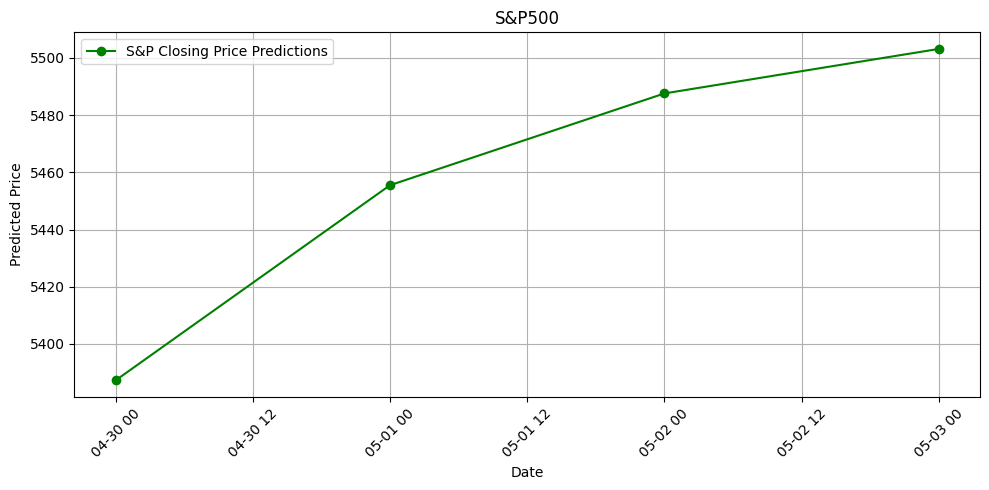

In [41]:
dates = []
prices = []
for pred in forecast_results:
    dates.append(pred['Date'])
    prices.append(pred['S&P500'])
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(dates, prices, marker='o', linestyle='-', color='green', label='S&P Closing Price Predictions')
plt.title('S&P500')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()